In [1]:
%pip install -r requirements.txt

In [2]:
import os
from typing import List, Dict, Tuple, Set, Optional, Union
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
%%bash

if ! command -v kaggle &> /dev/null; then
    echo "kaggle is not installed\nInstalling kaggle..."
    pip install kaggle
fi

mkdir -p ~/.kaggle

if [ -f "kaggle.json" ]; then
    echo "kaggle.json found. Copying to ~/.kaggle/"
    cp kaggle.json ~/.kaggle/
    chmod 600 ~/.kaggle/kaggle.json
else
    echo "Error: kaggle.json not found in the current directory. Please upload it."
fi

kaggle.json found. Copying to ~/.kaggle/


In [4]:
%%bash

if [ ! -d "Training" ] || [ ! -d "Testing" ]; then
  echo "Dataset not found\nDownloading dataset..."
  kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset --unzip
fi

Dataset not found\nDownloading dataset...
Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0



100%|██████████| 149M/149M [00:01<00:00, 98.9MB/s]


In [5]:
def get_class_paths(path: str):
  classes = []
  class_paths = []

  for label in os.listdir(path):
    label_path = os.path.join(path, label)

    if os.path.isdir(label_path):
      for image in os.listdir(label_path):
        image_path = os.path.join(label_path, image)

        classes.append(label)
        class_paths.append(image_path)

  df = pd.DataFrame({"class": classes, "path": class_paths})
  return df

In [6]:
tr_df = get_class_paths("Training")

In [7]:
tr_df.head()

,class,path
0,notumor,Training/notumor/Tr-no_0780.jpg
1,notumor,Training/notumor/Tr-no_0460.jpg
2,notumor,Training/notumor/Tr-no_0618.jpg
3,notumor,Training/notumor/Tr-no_1456.jpg
4,notumor,Training/notumor/Tr-no_0721.jpg


In [8]:
ts_df = get_class_paths("Testing")

In [9]:
ts_df.head()

,class,path
0,notumor,Testing/notumor/Te-no_0196.jpg
1,notumor,Testing/notumor/Te-no_0197.jpg
2,notumor,Testing/notumor/Te-no_0135.jpg
3,notumor,Testing/notumor/Te-no_0278.jpg
4,notumor,Testing/notumor/Te-noTr_0007.jpg


<ipython-input-10-b5bce9ca9fa3>:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")


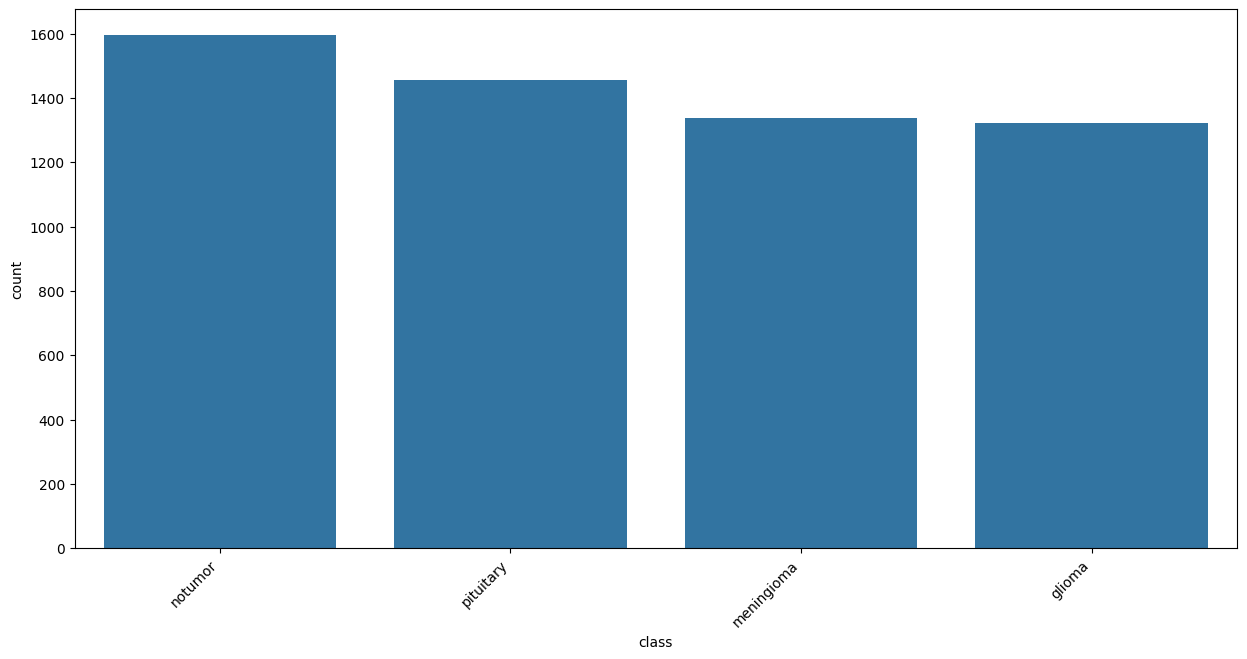

In [10]:
plt.figure(figsize=(15, 7))
ax = sns.countplot(x="class", data=tr_df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
plt.show()

<ipython-input-11-b877d1b72f0b>:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")


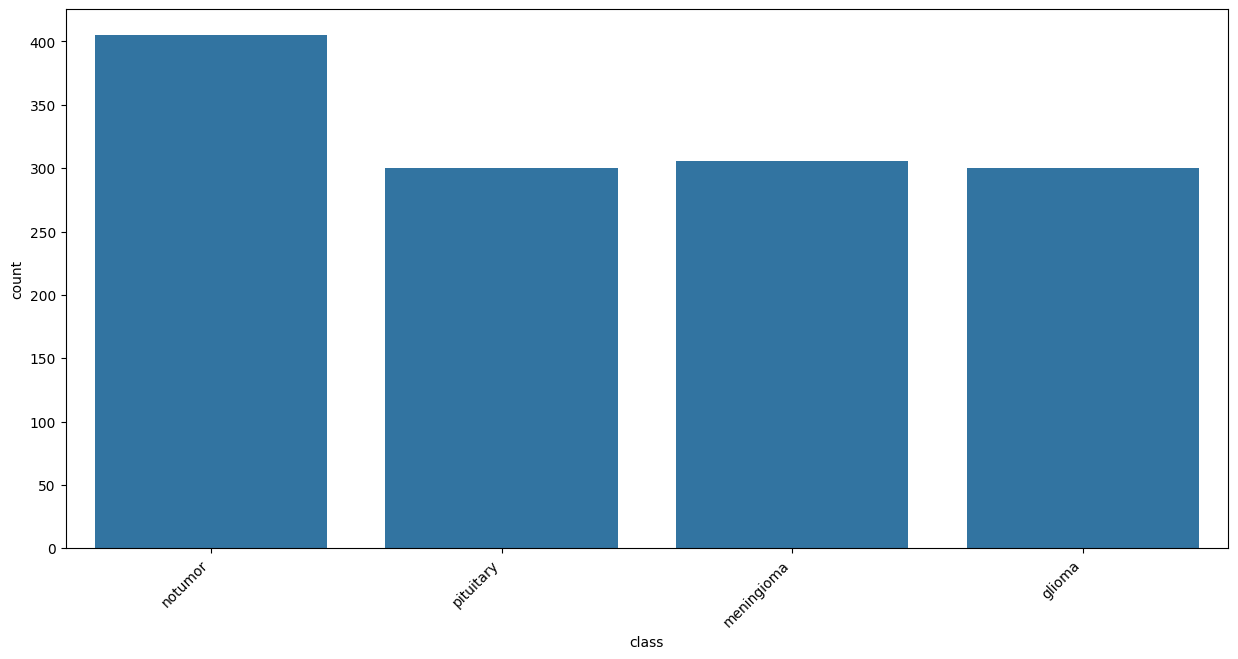

In [11]:
plt.figure(figsize=(15, 7))
ax = sns.countplot(x="class", data=ts_df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
plt.show()

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow import keras
from keras.src.layers import Lambda
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [13]:
valid_df, ts_df = train_test_split(ts_df, train_size=0.5, stratify=ts_df["class"])

In [14]:
valid_df.head()

,class,path
400,notumor,Testing/notumor/Te-no_0025.jpg
653,pituitary,Testing/pituitary/Te-pi_0130.jpg
1256,glioma,Testing/glioma/Te-gl_0098.jpg
406,pituitary,Testing/pituitary/Te-pi_0056.jpg
607,pituitary,Testing/pituitary/Te-pi_0215.jpg


In [15]:
ts_df.head()

,class,path
461,pituitary,Testing/pituitary/Te-pi_0142.jpg
684,pituitary,Testing/pituitary/Te-pi_0120.jpg
865,meningioma,Testing/meningioma/Te-me_0181.jpg
714,meningioma,Testing/meningioma/Te-me_0171.jpg
162,notumor,Testing/notumor/Te-no_0297.jpg


In [16]:
batch_size = 32

img_size: Tuple[int, int] = (299, 299)

image_generator = ImageDataGenerator(
    rescale=1/255,
    brightness_range=(0.8, 1.2),
)

ts_gen = ImageDataGenerator(rescale=1/255)

In [17]:
tr_gen = image_generator.flow_from_dataframe(
  tr_df,
  x_col="path",
  y_col="class",
  target_size=img_size,
  batch_size=batch_size,
  class_mode="categorical",
  subset="training"
)

valid_gen = image_generator.flow_from_dataframe(
  valid_df,
  x_col="path",
  y_col="class",
  target_size=img_size,
  batch_size=batch_size,
  class_mode="categorical"
)

ts_gen = ts_gen.flow_from_dataframe(
  ts_df,
  x_col="path",
  y_col="class",
  target_size=img_size,
  batch_size=batch_size,
  shuffle=False,
  class_mode="categorical"
)

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


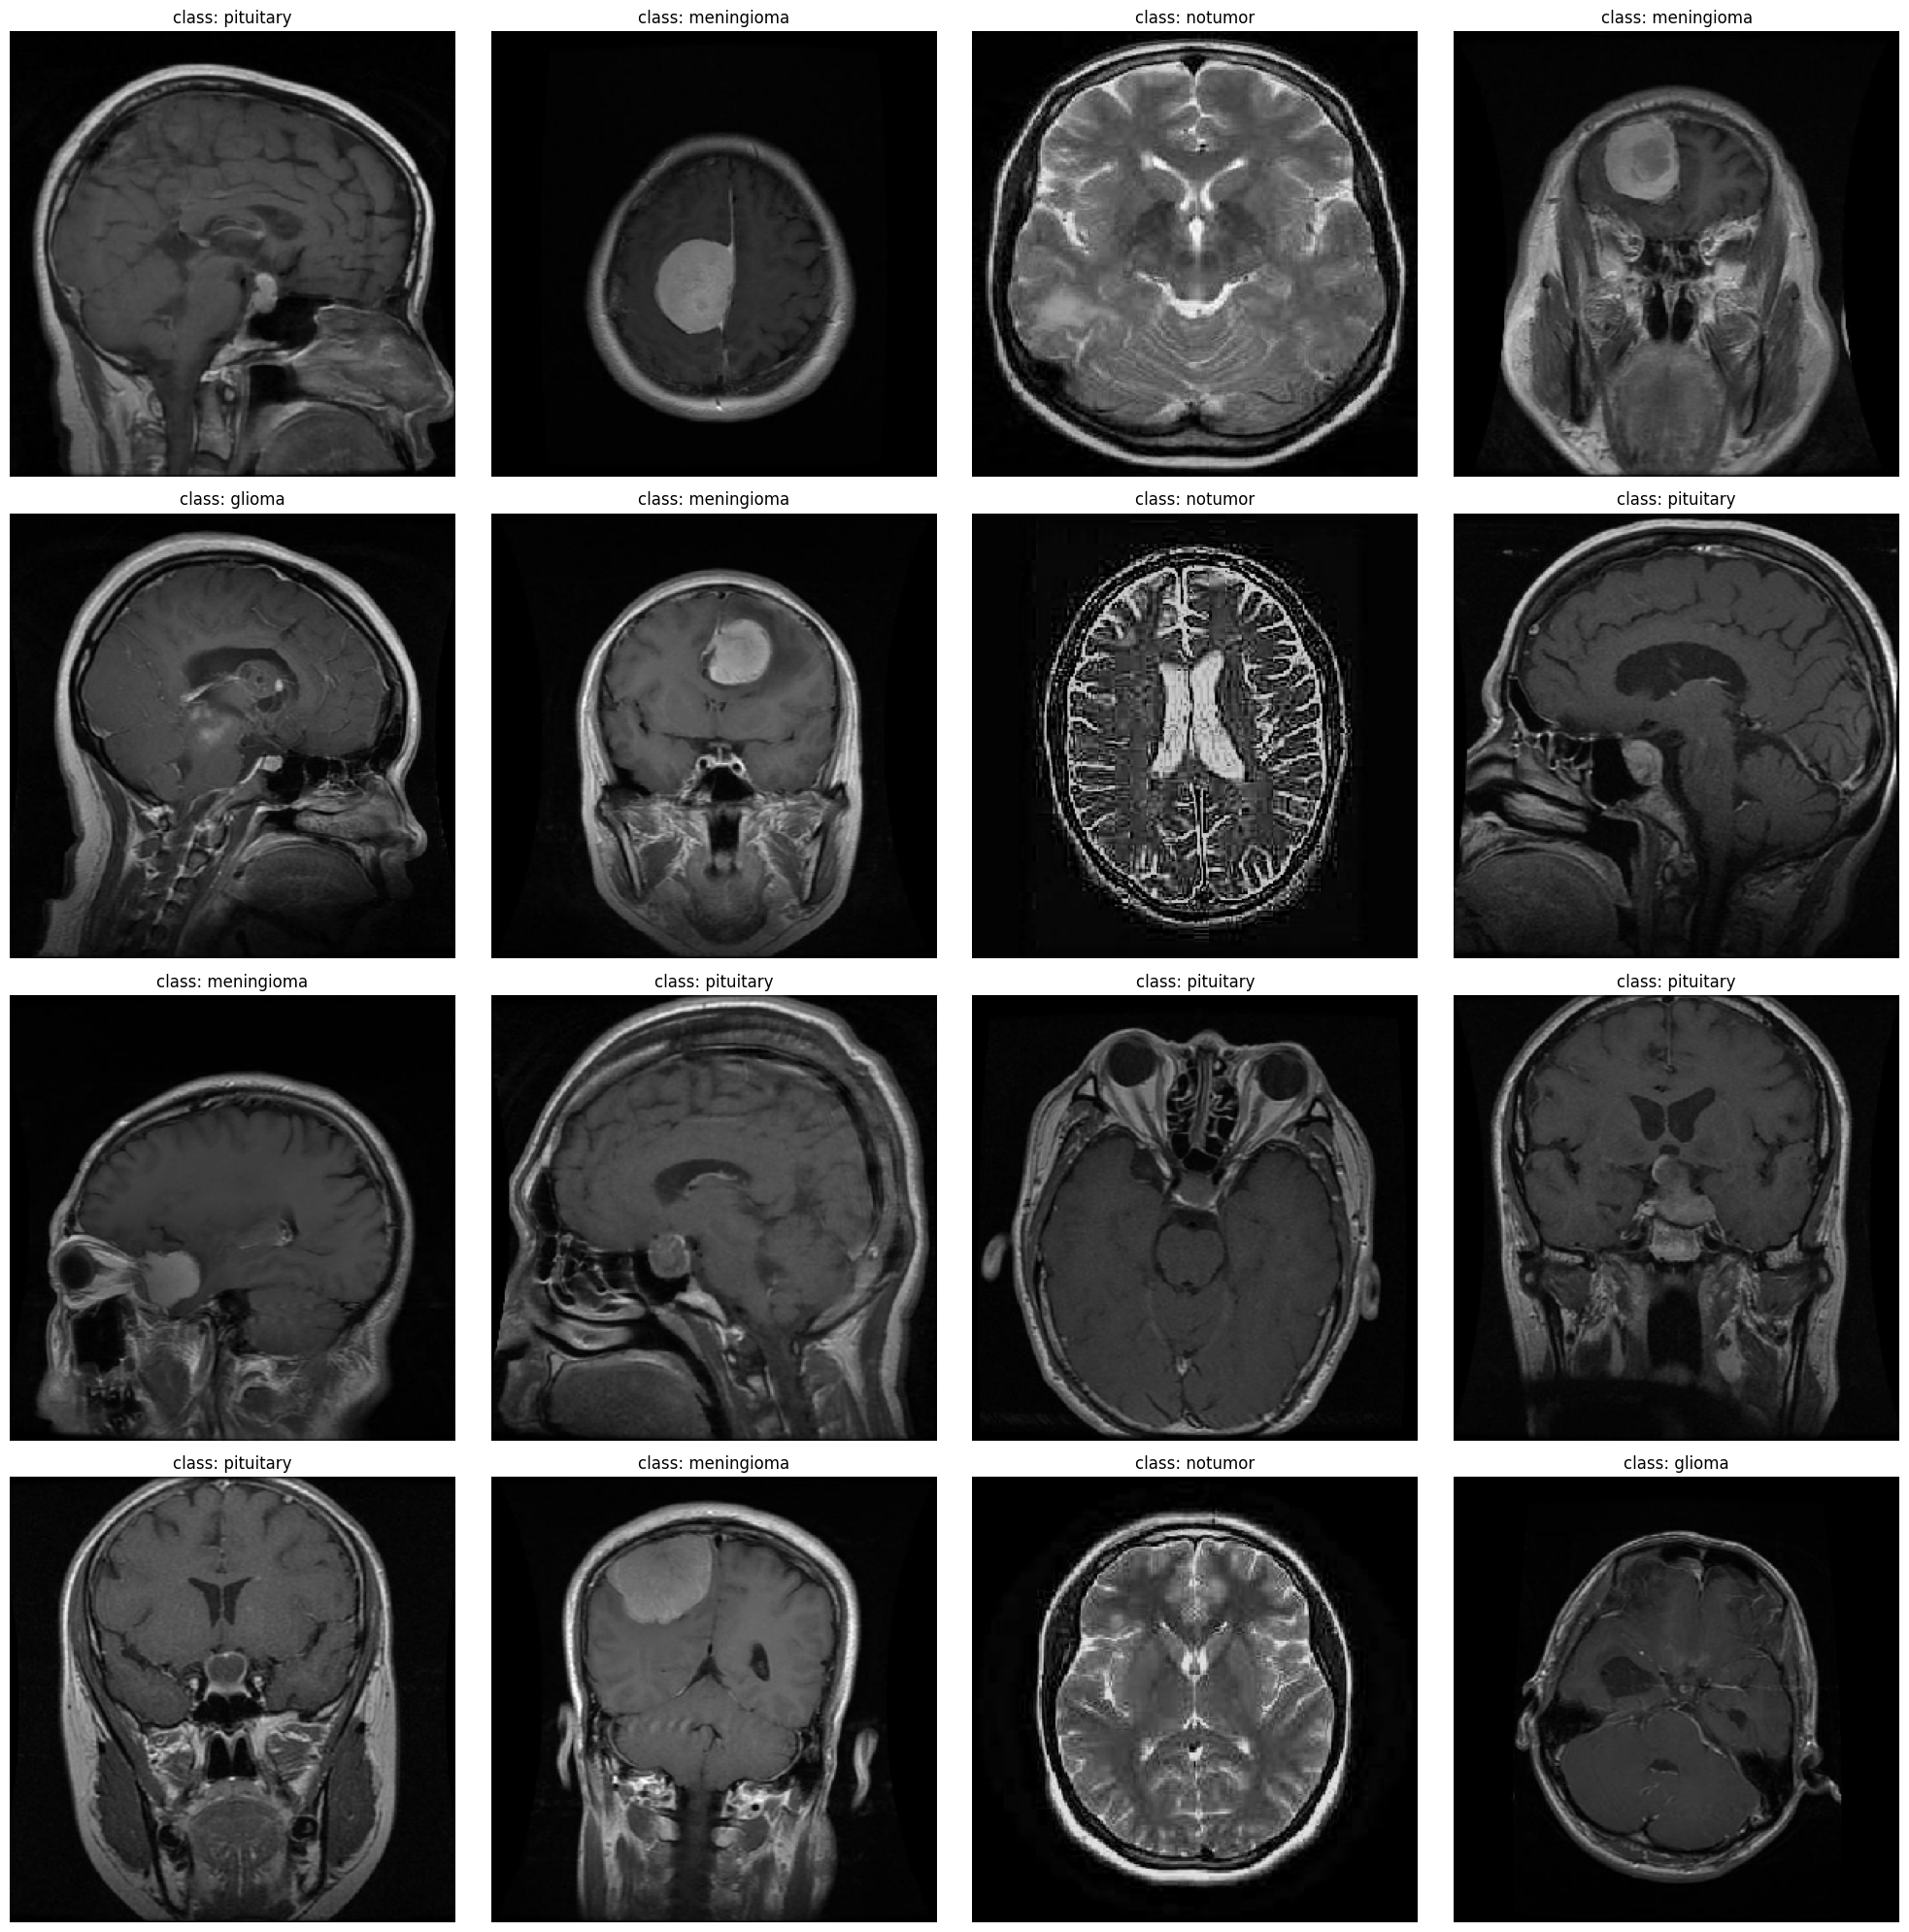

In [18]:
plt.figure(figsize=(20, 20))
for i in range(16):
  plt.subplot(4, 4, i + 1)
  batch = next(tr_gen)
  image = batch[0][0]
  label = batch[1][0]
  plt.imshow(image)

  class_index = np.argmax(label)

  class_names = list(tr_gen.class_indices.keys())
  class_indicies = list(tr_gen.class_indices.values())

  index_position = class_indicies.index(class_index)

  class_name = class_names[index_position]

  plt.title(f'class: {class_name}')
  plt.axis("off")

plt.tight_layout()
plt.show()


In [19]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [20]:
import tensorflow as tf

# Configure GPU memory growth before any other TensorFlow/Keras operations
print("TensorFlow version:", tf.__version__)
print("ROCm devices available:", tf.config.list_physical_devices('GPU'))

physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.set_visible_devices(physical_devices[0], 'GPU')
else:
    print("No GPU devices found")

#Now import Keras and perform other operations
import keras
keras.mixed_precision.set_global_policy('mixed_float16')

TensorFlow version: 2.17.0
ROCm devices available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [21]:
img_shape: Tuple[int, int, int] = (299, 299, 3)

base_model = tf.keras.applications.Xception(
  include_top=False,
  weights="imagenet",
  input_shape=img_shape,
  pooling="max"
)

input_tensor = Input(shape=img_shape)
processed_input = Lambda(lambda x: x)(input_tensor)
xception_output = base_model(processed_input)

model = Sequential([
  Input(shape=img_shape),
  base_model,
  Flatten(),
  Dropout(0.3),
  Dense(128, activation="relu"),
  Dropout(rate=0.25),
  Dense(4, activation="softmax")
])


83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [22]:
model.compile(
  Adamax(learning_rate=0.001),
  loss="categorical_crossentropy",
  metrics=["accuracy", Precision(), Recall()]
)

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ xception (Functional)                │ (None, 2048)                │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,124,268 (80.58 MB)

 Trainable params: 21,069,740 (80.37 MB)

 Non-trainable params: 54,528 (213.00 KB)

In [23]:
hist = model.fit(
    tr_gen,
    epochs=5,
    validation_data=valid_gen,
)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


179/179 ━━━━━━━━━━━━━━━━━━━━ 238s 626ms/step - accuracy: 0.6237 - loss: 1.3113 - precision: 0.6860 - recall: 0.5182 - val_accuracy: 0.8870 - val_loss: 0.2974 - val_precision: 0.9039 - val_recall: 0.8763
Epoch 2/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 99s 276ms/step - accuracy: 0.9730 - loss: 0.0889 - precision: 0.9746 - recall: 0.9703 - val_accuracy: 0.9435 - val_loss: 0.1660 - val_precision: 0.9464 - val_recall: 0.9435
Epoch 3/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 81s 273ms/step - accuracy: 0.9907 - loss: 0.0326 - precision: 0.9914 - recall: 0.9887 - val_accuracy: 0.9542 - val_loss: 0.1381 - val_precision: 0.9557 - val_recall: 0.9542
Epoch 4/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 51s 281ms/step - accuracy: 0.9933 - loss: 0.0245 - precision: 0.9936 - recall: 0.9932 - val_accuracy: 0.9863 - val_loss: 0.0285 - val_precision: 0.9877 - val_recall: 0.9847
Epoch 5/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 81s 272ms/step - accuracy: 0.9953 - loss: 0.0184 - precision: 0.9958 - recall: 0.9953 - val_accuracy: 0.9939 - val_loss: 0

In [24]:
hist.history

{'accuracy': [0.8160014152526855,
  0.9739145636558533,
  0.9917716979980469,
  0.993697464466095,
  0.9947478771209717],
 'loss': [0.579582691192627,
  0.08282198756933212,
  0.02727089636027813,
  0.02183893695473671,
  0.01643317937850952],
 'precision': [0.8767150640487671,
  0.9753910899162292,
  0.9921121597290039,
  0.994218647480011,
  0.9952706098556519],
 'recall': [0.7606792449951172,
  0.9714635610580444,
  0.9908963441848755,
  0.9935224056243896,
  0.9947478771209717],
 'val_accuracy': [0.8870229125022888,
  0.943511426448822,
  0.9541984796524048,
  0.9862595200538635,
  0.9938931465148926],
 'val_loss': [0.29741171002388,
  0.1660240888595581,
  0.13805125653743744,
  0.028502771630883217,
  0.02461107261478901],
 'val_precision': [0.9039369821548462,
  0.9464012384414673,
  0.9556574821472168,
  0.9877488613128662,
  0.9938650131225586],
 'val_recall': [0.876335859298706,
  0.943511426448822,
  0.9541984796524048,
  0.9847328066825867,
  0.989313006401062]}

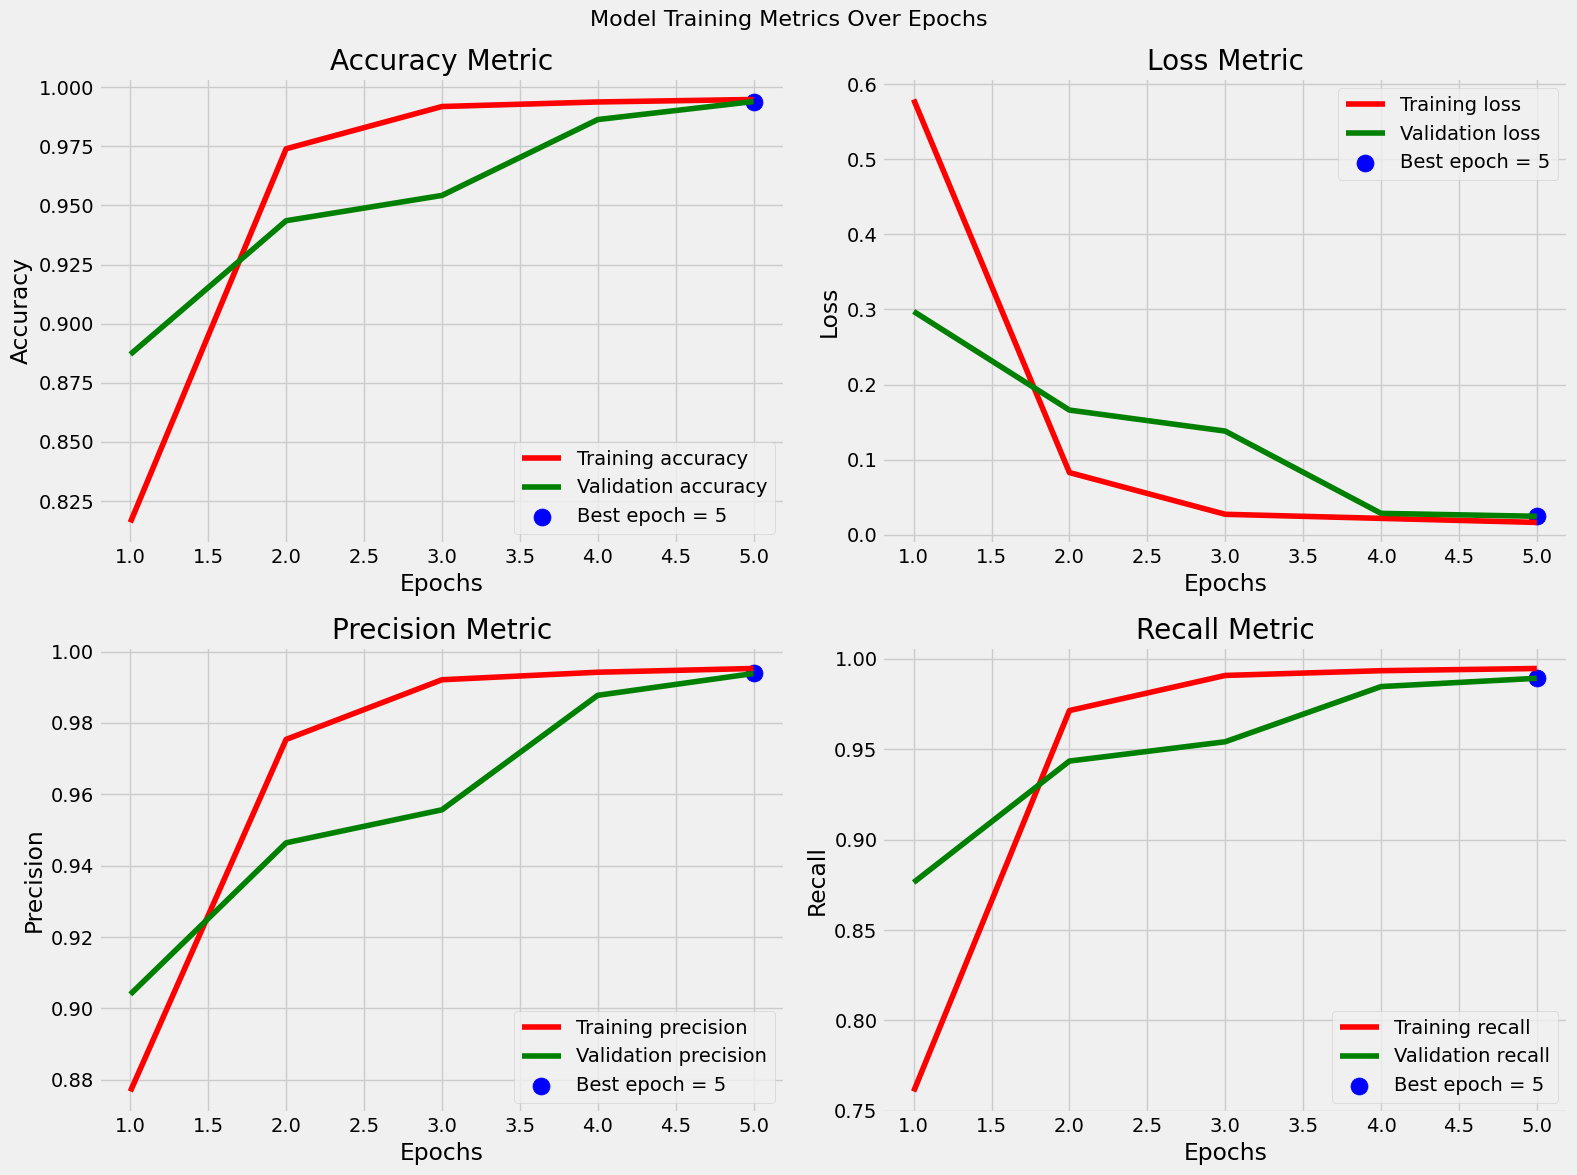

In [27]:
# Visualize training metrics over epochs
#
# This code creates a 2x2 grid of plots showing the training and validation metrics 
# (accuracy, loss, precision, recall) over epochs. For each metric, it:
# - Plots training and validation curves
# - Highlights the best performing epoch
# - Shows the progression across all training epochs
#
# Args:
#   hist: History object from model.fit() containing training metrics
#
# Returns:
#   None. Displays a figure with 4 subplots showing metric progression.

import numpy as np
import matplotlib.pyplot as plt

# Extract metrics from training history
metrics = ["accuracy", "loss", "precision", "recall"]
tr_metrics = {m: hist.history[m] for m in metrics}
val_metrics = {m: hist.history[f"val_{m}"] for m in metrics}

# Find best epoch for each metric
best_epochs = {}
best_values = {}
for m in metrics:
    if m == 'loss':
        idx = np.argmin(val_metrics[m])  # Minimize loss
    else:
        idx = np.argmax(val_metrics[m])  # Maximize other metrics
    best_epochs[m] = idx + 1
    best_values[m] = val_metrics[m][idx]

# Create figure with 2x2 subplots
plt.figure(figsize=(16, 12))
plt.style.use('fivethirtyeight')

# Plot each metric
for i, metric in enumerate(metrics):
    plt.subplot(2, 2, i+1)
    epochs = range(1, len(tr_metrics[metric]) + 1)

    # Plot training curve
    plt.plot(
        epochs,
        tr_metrics[metric],
        'r-',
        label=f'Training {metric}'
    )
    
    # Plot validation curve
    plt.plot(
        epochs,
        val_metrics[metric],
        'g-',
        label=f'Validation {metric}'
    )
    
    # Highlight best epoch
    plt.scatter(
        best_epochs[metric],
        best_values[metric],
        s=150,
        c='b',
        label=f'Best epoch = {best_epochs[metric]}'
    )

    # Add labels and styling
    title = f'{metric.capitalize()} Metric'
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.grid(True)

plt.suptitle('Model Training Metrics Over Epochs', fontsize=16)
plt.tight_layout()
plt.show()

In [28]:
train_score = model.evaluate(tr_gen, verbose=1)
valid_score = model.evaluate(valid_gen, verbose=1)
test_score = model.evaluate(ts_gen, verbose=1)

print(f"Train Accuracy: {train_score[1]*100:.2f}%")
print(f"Train Loss: {train_score[0]:.4f}")
print(f"\nValidation Accuracy: {valid_score[1]*100:.2f}%")
print(f"Validation Loss: {valid_score[0]:.4f}")
print(f"\n\nTest Accuracy: {test_score[1]*100:.2f}%")
print(f"Test Loss: {test_score[0]:.4f}")

179/179 ━━━━━━━━━━━━━━━━━━━━ 33s 187ms/step - accuracy: 0.9959 - loss: 0.0109 - precision: 0.9963 - recall: 0.9956
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 172ms/step - accuracy: 0.9931 - loss: 0.0278 - precision: 0.9930 - recall: 0.9917
 1/21 ━━━━━━━━━━━━━━━━━━━━ 3s 193ms/step - accuracy: 1.0000 - loss: 3.9328e-04 - precision: 1.0000 - recall: 1.0000

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 0.9838 - loss: 0.0842 - precision: 0.9838 - recall: 0.9838
Train Accuracy: 99.68%
Train Loss: 0.0093

Validation Accuracy: 98.93%
Validation Loss: 0.0335


Test Accuracy: 97.71%
Test Loss: 0.1223


21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 228ms/step


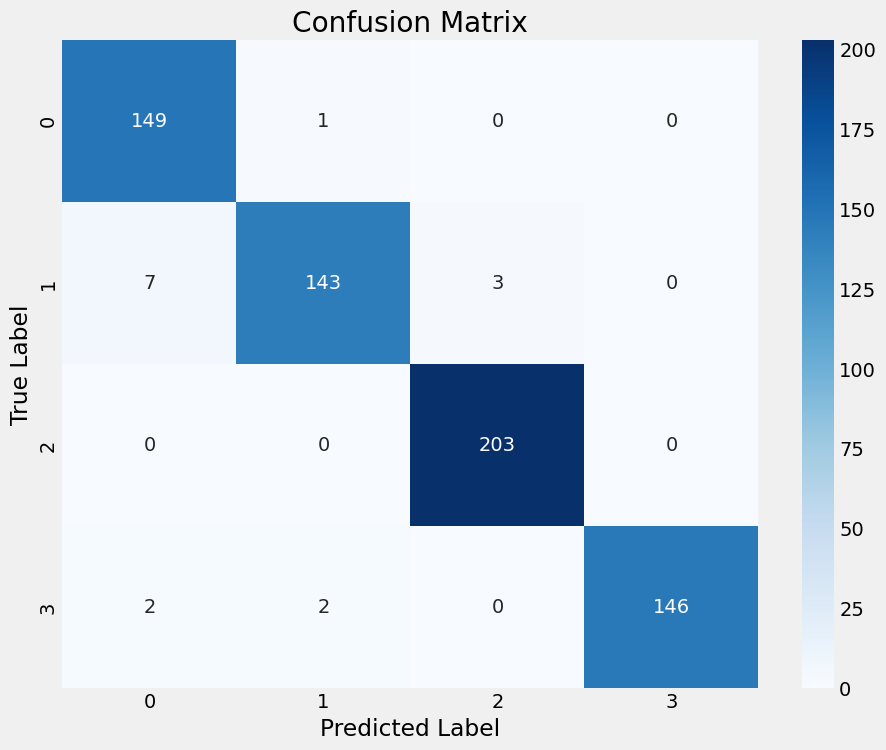

In [29]:
preds = model.predict(ts_gen)
y_pred = np.argmax(preds, axis=1)

class_dict = {
    0: "glioma",
    1: "meningioma",
    2: "no_tumor",
    3: "pituitary"
}

cm = confusion_matrix(ts_gen.classes, y_pred)
labels = list(class_dict.keys())
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=labels,
    yticklabels=labels
  )
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [30]:
from PIL import Image

def predict(img_path: str) ->  None:
  labels = list(class_dict.keys())

  plt.figure(figsize=(6, 8))

  img = Image.open(img_path)
  resized_img = img.resize((299, 299))
  img_array = np.array(resized_img)
  img_array = np.expand_dims(img_array, axis=0) / 255.0

  predictions = model.predict(img_array)
  probabilities = list(predictions[0])

  predicted_class_idx = np.argmax(probabilities)
  predicted_class = labels[predicted_class_idx]

  plt.subplot(2, 1, 1)
  plt.imshow(resized_img)
  plt.title(f"Input MRI Image\nPredicted {predicted_class}")


  plt.subplot(2, 1, 2 )
  bars = plt.barh(labels, probabilities)
  plt.xlabel("Probability", fontsize=15)
  plt.title("Class Probabilities")

  ax = plt.gca()
  ax.bar_label(bars, fmt='%.2f')

  plt.tight_layout()
  plt.show()

  print(f"\nPredicted tumor types: {predicted_class}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


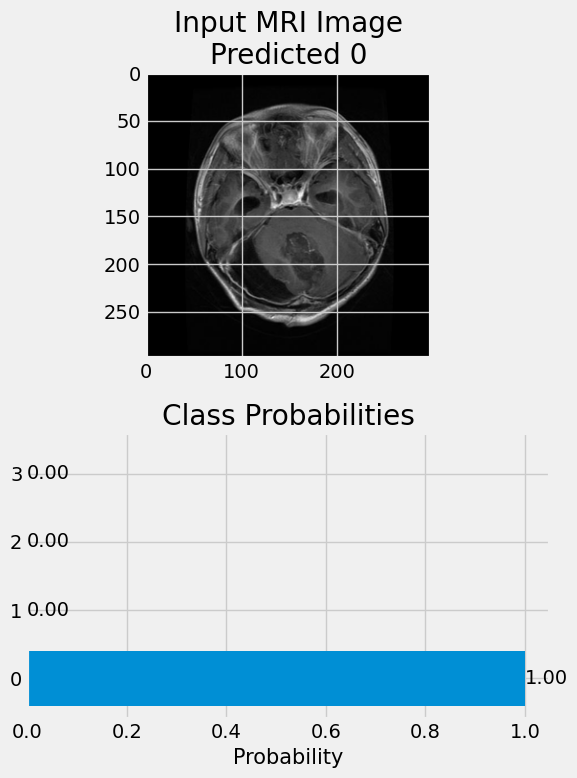


Predicted tumor types: 0


In [31]:
predict("/content/Testing/glioma/Te-glTr_0000.jpg")

In [32]:
model.save_weights("xception_model.weights.h5")

In [33]:
from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras import regularizers

In [34]:
batch_size = 16

img_size: Tuple[int, int] = (224, 224)

image_generator = ImageDataGenerator(
    rescale=1/255,
    brightness_range=(0.8, 1.2),
)

ts_gen = ImageDataGenerator(rescale=1/255)
tr_gen = image_generator.flow_from_dataframe(
  tr_df,
  x_col="path",
  y_col="class",
  target_size=img_size,
  batch_size=batch_size,
  class_mode="categorical",
  subset="training"
)

valid_gen = image_generator.flow_from_dataframe(
  valid_df,
  x_col="path",
  y_col="class",
  target_size=img_size,
  batch_size=batch_size,
  class_mode="categorical"
)

ts_gen = ts_gen.flow_from_dataframe(
  ts_df,
  x_col="path",
  y_col="class",
  target_size=img_size,
  batch_size=batch_size,
  shuffle=False,
  class_mode="categorical"
)

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


In [35]:
cnn_model = Sequential()

cnn_model.add(Conv2D(256, (3, 3), padding='same', input_shape=(224, 224, 3), activation='relu'))
cnn_model.add(MaxPool2D(pool_size=(2, 2)))

cnn_model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
cnn_model.add(MaxPool2D(pool_size=(2, 2)))
cnn_model.add(Dropout(0.25))

cnn_model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
cnn_model.add(MaxPool2D(pool_size=(2, 2)))
cnn_model.add(Dropout(0.25))

cnn_model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
cnn_model.add(MaxPool2D(pool_size=(2, 2)))

cnn_model.add(Flatten())

cnn_model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
cnn_model.add(Dropout(0.25))

cnn_model.add(Dense(4, activation='softmax'))

cnn_model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy', Precision(), Recall()])

cnn_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 224, 224, 256)       │           7,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 256)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 112, 112, 256)       │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 56, 56, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 56, 56, 128)         │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 28, 28, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │       3,211,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,178,628 (15.94 MB)

 Trainable params: 4,178,628 (15.94 MB)

 Non-trainable params: 0 (0.00 B)

In [36]:
history = cnn_model.fit(tr_gen, epochs=5, validation_data=valid_gen)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


357/357 ━━━━━━━━━━━━━━━━━━━━ 70s 115ms/step - accuracy: 0.5707 - loss: 2.1422 - precision_1: 0.7002 - recall_1: 0.3986 - val_accuracy: 0.7603 - val_loss: 0.8948 - val_precision_1: 0.8056 - val_recall_1: 0.5756
Epoch 2/5
357/357 ━━━━━━━━━━━━━━━━━━━━ 30s 82ms/step - accuracy: 0.8117 - loss: 0.6864 - precision_1: 0.8384 - recall_1: 0.7776 - val_accuracy: 0.7771 - val_loss: 0.6864 - val_precision_1: 0.7947 - val_recall_1: 0.7267
Epoch 3/5
357/357 ━━━━━━━━━━━━━━━━━━━━ 44s 91ms/step - accuracy: 0.8602 - loss: 0.5119 - precision_1: 0.8755 - recall_1: 0.8433 - val_accuracy: 0.8443 - val_loss: 0.5329 - val_precision_1: 0.8549 - val_recall_1: 0.8275
Epoch 4/5
357/357 ━━━━━━━━━━━━━━━━━━━━ 40s 89ms/step - accuracy: 0.8921 - loss: 0.4146 - precision_1: 0.9015 - recall_1: 0.8819 - val_accuracy: 0.9023 - val_loss: 0.3981 - val_precision_1: 0.9092 - val_recall_1: 0.8870
Epoch 5/5
357/357 ━━━━━━━━━━━━━━━━━━━━ 29s 79ms/step - accuracy: 0.9256 - loss: 0.3341 - precision_1: 0.9297 - recall_1: 0.9218 - val

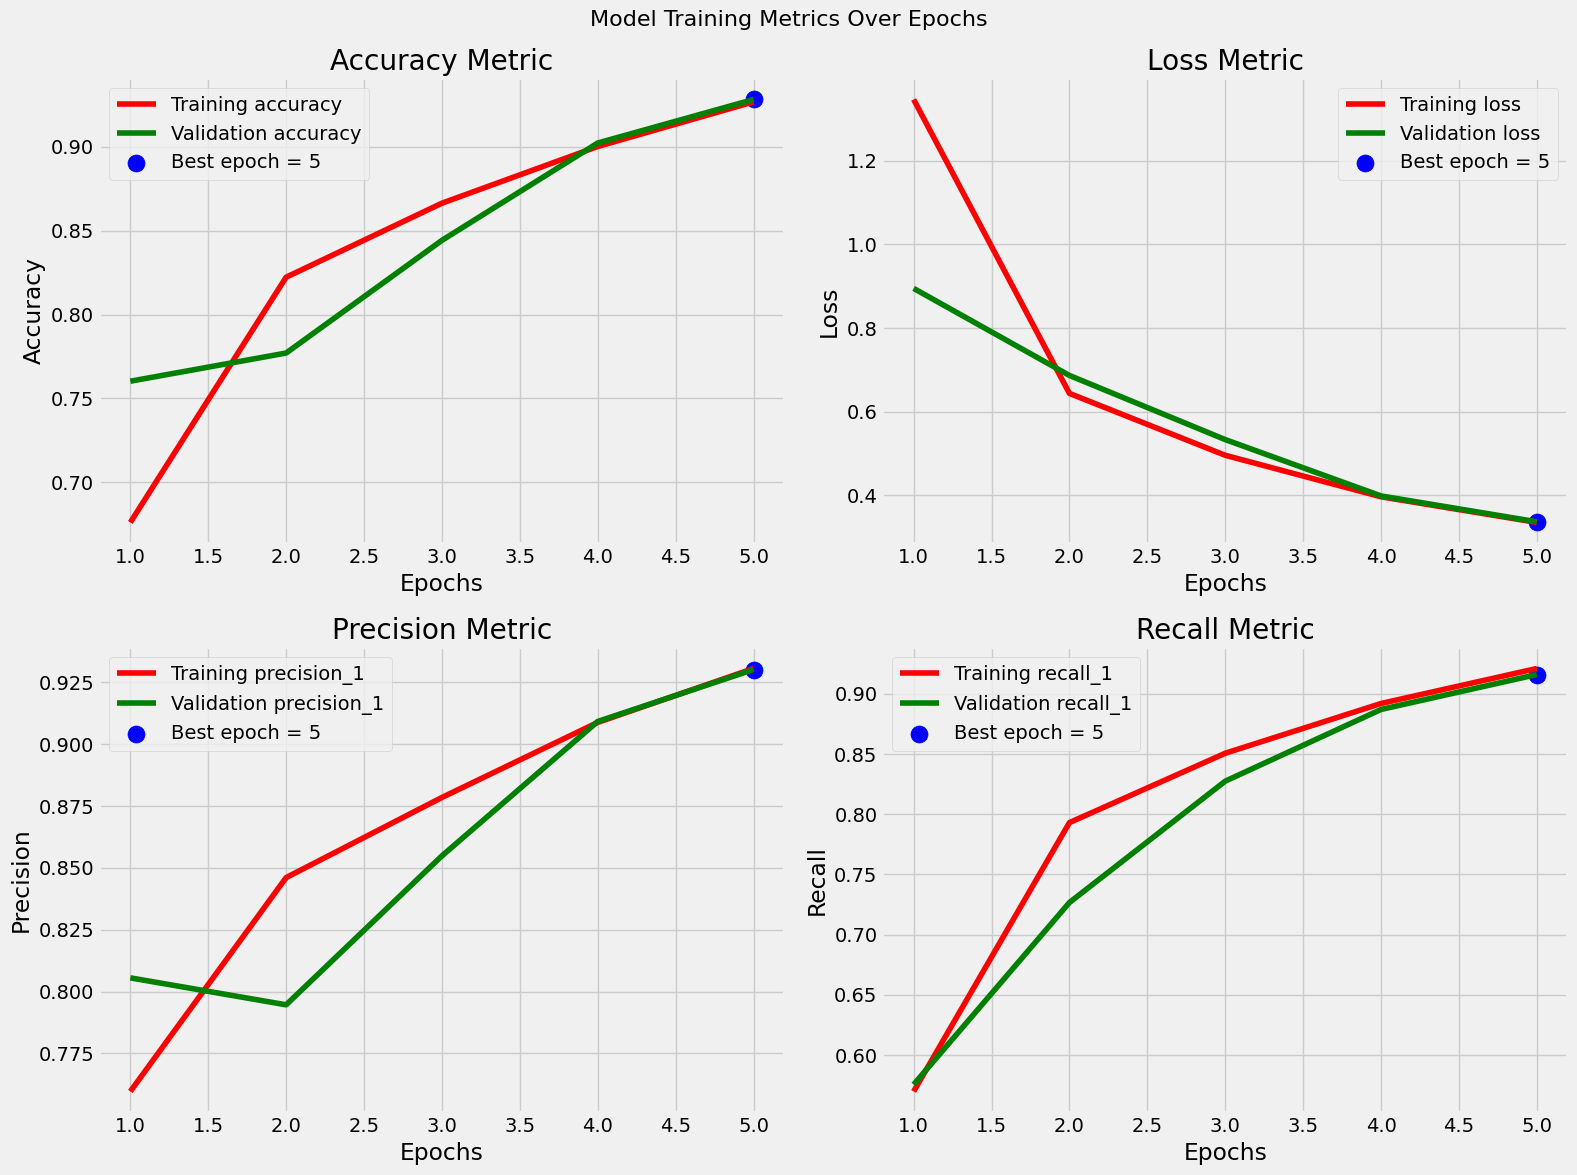

In [37]:
import numpy as np
import matplotlib.pyplot as plt

metrics = ["accuracy", "loss", "precision_1", "recall_1"]
tr_metrics = {m: history.history[m] for m in metrics}
val_metrics = {m: history.history[f"val_{m}"] for m in metrics}

best_epochs = {}
best_values = {}

for m in metrics:
    if m == 'loss':
        idx = np.argmin(val_metrics[m])
    else:
        idx = np.argmax(val_metrics[m])

    best_epochs[m] = idx + 1
    best_values[m] = val_metrics[m][idx]

plt.figure(figsize=(16, 12))
plt.style.use('fivethirtyeight')

for i, metric in enumerate(metrics):
    plt.subplot(2, 2, i+1)
    epochs = range(1, len(tr_metrics[metric]) + 1)

    plt.plot(
        epochs,
        tr_metrics[metric],
        'r-',
        label=f'Training {metric}'
    )
    plt.plot(
        epochs,
        val_metrics[metric],
        'g-',
        label=f'Validation {metric}'
    )
    plt.scatter(
        best_epochs[metric],
        best_values[metric],
        s=150,
        c='b',
        label=f'Best epoch = {best_epochs[metric]}'
    )

    title = f'{metric.replace("_1", "").capitalize()} Metric'
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel(metric.replace('_1', "").capitalize())
    plt.legend()
    plt.grid(True)

plt.suptitle('Model Training Metrics Over Epochs', fontsize=16)
plt.tight_layout()
plt.show()

In [38]:
train_score = cnn_model.evaluate(tr_gen, verbose=1)
valid_score = cnn_model.evaluate(valid_gen, verbose=1)
test_score = cnn_model.evaluate(ts_gen, verbose=1)

print(f"Train Accuracy: {train_score[1]*100:.2f}%")
print(f"Train Loss: {train_score[0]:.4f}")
print(f"\nValidation Accuracy: {valid_score[1]*100:.2f}%")
print(f"Validation Loss: {valid_score[0]:.4f}")
print(f"\n\nTest Accuracy: {test_score[1]*100:.2f}%")
print(f"Test Loss: {test_score[0]:.4f}")

357/357 ━━━━━━━━━━━━━━━━━━━━ 22s 61ms/step - accuracy: 0.9670 - loss: 0.2442 - precision_1: 0.9699 - recall_1: 0.9633
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.9001 - loss: 0.3837 - precision_1: 0.9173 - recall_1: 0.9000
 3/41 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.9444 - loss: 0.2990 - precision_1: 0.9444 - recall_1: 0.9444

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.9137 - loss: 0.3354 - precision_1: 0.9164 - recall_1: 0.9090
Train Accuracy: 96.50%
Train Loss: 0.2488

Validation Accuracy: 91.76%
Validation Loss: 0.3385


Test Accuracy: 89.94%
Test Loss: 0.3690


41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step


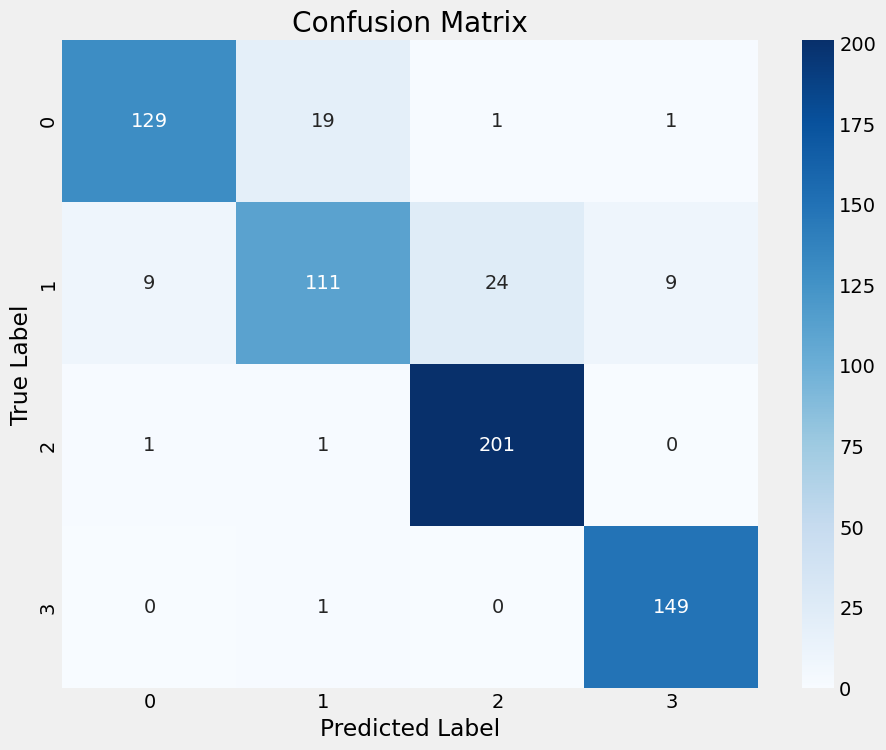

In [39]:
preds = cnn_model.predict(ts_gen)
y_pred = np.argmax(preds, axis=1)

class_dict = {
    0: "glioma",
    1: "meningioma",
    2: "no_tumor",
    3: "pituitary"
}

cm = confusion_matrix(ts_gen.classes, y_pred)
labels = list(class_dict.keys())
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=labels,
    yticklabels=labels
  )
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [40]:
clr = classification_report(ts_gen.classes, y_pred)
print(clr)

              precision    recall  f1-score   support

           0       0.93      0.86      0.89       150
           1       0.84      0.73      0.78       153
           2       0.89      0.99      0.94       203
           3       0.94      0.99      0.96       150

    accuracy                           0.90       656
   macro avg       0.90      0.89      0.89       656
weighted avg       0.90      0.90      0.90       656



In [41]:
cnn_model.save("cnn_model.h5")